In [1]:
import os
import csv
import ast
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

from utils import savefig

plt.rcParams['font.size'] = 14

In [2]:
colormap = {
    "forward_asymmetry": "tab:purple",
    "temporal_factor": "tab:blue",
    "explained_variance": "tab:green",
    "cross_decoding": "tab:orange",
    "accuracy": "black"
}

In [3]:

def plot_mean_std_scatter(x, y, yerr, x_scatter, y_scatter, x_label, y_label, color='tab:blue', figname=None, vary_x=0.1):
    fig = plt.figure(figsize=(4.3, 3.3), dpi=180)
    plt.errorbar(np.arange(len(y))-vary_x, y, yerr=yerr, fmt='o', alpha=0.8, capsize=3, color=color)
    unique_x_values = np.unique(x_scatter)
    data_to_plot = [y_scatter[x_scatter == x_val] for x_val in unique_x_values]
    # plt.boxplot(data_to_plot, positions=np.arange(len(unique_x_values)) - vary_x, widths=0.1)
    
    # Update the scatter plot to use integer x-axis
    x_scatter_int = np.array([np.where(unique_x_values == x)[0][0] for x in x_scatter])
    plt.scatter(x_scatter_int + vary_x, y_scatter, alpha=0.3, color=color, s=15)
    plt.xticks(ticks=range(len(unique_x_values)), labels=[f"{x_val}" for x_val in unique_x_values])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if figname:
        savefig("./figures/vary_gamma", figname)
    else:
        plt.show()


def plot_scatter(x, y, x_label, y_label, color='tab:blue', figname=None):
    plt.figure(figsize=(4, 3.5), dpi=180)
    plt.scatter(x, y, alpha=0.5, color=color)

    # Reshape x and y for sklearn
    x_reshaped = np.array(x).reshape(-1, 1)
    y_reshaped = np.array(y).reshape(-1, 1)

    # Fit linear regression model
    model = LinearRegression()
    model.fit(x_reshaped, y_reshaped)

    # Predict y values
    sorted_x_idx = np.argsort(x_reshaped.reshape(-1))
    x1, x2 = x_reshaped[sorted_x_idx[0]], x_reshaped[sorted_x_idx[-1]]
    y_pred = model.predict(x_reshaped)
    y1, y2 = y_pred[sorted_x_idx[0]], y_pred[sorted_x_idx[-1]]

    # Calculate R-squared
    r2 = r2_score(y_reshaped, y_pred)
    # Calculate the p-value for the regression
    _, p_value = stats.pearsonr(x_reshaped.flatten(), y_reshaped.flatten())
    
    # Plot the regression line
    plt.plot([x1, x2], [y1, y2], color=color)

    plt.ylabel(y_label)
    plt.xlabel(x_label+"\n(R² = {:.2f}, p = {:.3f})".format(r2, p_value))

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if figname:
        savefig("./figures/scatter", figname)
    else:
        plt.show()

In [4]:
def load_data(path, training_data_path, model_num, exp, paramters, training_data_length=200):
    data_single_model = {}
    with open(path/"contiguity_effect.csv", "r") as f:
        reader = csv.reader(f)
        for row in reader:
            data_single_model["model_num"] = model_num
            data_single_model["exp"] = exp

            for key, value in paramters.items():
                data_single_model[key] = value

            data_single_model["accuracy"] = float(row[0])
            data_single_model["forward_asymmetry"] = float(row[1])
            data_single_model["temporal_factor"] = float(row[2])

            classifier_data = pickle.load(open(path/"ridge_classifier_stat.pkl", "rb"))
            data_single_model["index_decoding_accuracy_encoding_phase"] = classifier_data["index_enc_acc"]
            data_single_model["item_decoding_accuracy_encoding_phase"] = classifier_data["item_enc_acc"]
            data_single_model["last_item_decoding_accuracy_encoding_phase"] = classifier_data["item_enc_acc_last"]
            data_single_model["index_decoding_accuracy_recall_phase"] = classifier_data["index_rec_acc"]
            data_single_model["item_decoding_accuracy_recall_phase"] = classifier_data["item_rec_acc"]
            data_single_model["last_item_decoding_accuracy_recall_phase"] = classifier_data["item_rec_acc_last"]
            data_single_model["index_decoding_accuracy"] = (data_single_model["index_decoding_accuracy_encoding_phase"] + data_single_model["index_decoding_accuracy_recall_phase"]) / 2
            data_single_model["item_decoding_accuracy"] = (data_single_model["item_decoding_accuracy_encoding_phase"] + data_single_model["item_decoding_accuracy_recall_phase"]) / 2
            data_single_model["last_item_decoding_accuracy"] = (data_single_model["last_item_decoding_accuracy_encoding_phase"] + data_single_model["last_item_decoding_accuracy_recall_phase"]) / 2

            explained_variance_data = np.load(path/"explained_variance.npy")
            data_single_model["explained_variance_encoding_index"] = explained_variance_data[0]
            data_single_model["explained_variance_recall_index"] = explained_variance_data[1]
            data_single_model["explained_variance_index"] = (data_single_model["explained_variance_encoding_index"] + data_single_model["explained_variance_recall_index"]) / 2
            data_single_model["explained_variance_encoding_identity"] = explained_variance_data[2]
            data_single_model["explained_variance_recall_identity"] = explained_variance_data[3]
            data_single_model["explained_variance_identity"] = (data_single_model["explained_variance_encoding_identity"] + data_single_model["explained_variance_recall_identity"]) / 2

            cross_decoding_data = np.load(path/"cross_acc.npy")
            data_single_model["cross_decoding_accuracy_index_rec_enc"] = cross_decoding_data[0]
            data_single_model["cross_decoding_accuracy_identity_rec_enc"] = cross_decoding_data[1]
            data_single_model["cross_decoding_accuracy_index_enc_rec"] = cross_decoding_data[2]
            data_single_model["cross_decoding_accuracy_identity_enc_rec"] = cross_decoding_data[3]
            data_single_model["cross_decoding_accuracy_index"] = (data_single_model["cross_decoding_accuracy_index_rec_enc"] + data_single_model["cross_decoding_accuracy_index_enc_rec"]) / 2
            data_single_model["cross_decoding_accuracy_identity"] = (data_single_model["cross_decoding_accuracy_identity_rec_enc"] + data_single_model["cross_decoding_accuracy_identity_enc_rec"]) / 2

            try:
                training_data = np.load(training_data_path/"accuracy_2.npy")
            except:
                training_data = np.load(training_data_path/"accuracy_1.npy")
            # find the final consecutive zeros in the training data and set it to the last non-zero value
            zero_indices = np.where(training_data == 0)[0]
            if len(zero_indices) > 0:
                last_zero_index = zero_indices[0]
                training_data[last_zero_index:] = training_data[last_zero_index-1]
            if training_data.shape[0] < training_data_length:
                training_data = np.pad(training_data, (0, training_data_length - training_data.shape[0]), mode='constant', constant_values=training_data[-1])
            data_single_model["training_accuracy"] = training_data

            break
    return data_single_model


In [5]:
def load_perturbation_data(path):
    perturbation_accuracies = np.load(path/"perturbation_accuracies.npy")
    return perturbation_accuracies

### Load data

In [6]:
gamma_names = ["0", "02", "04", "06", "08", "10"]
temporal_discount_factors = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
noise_levels = [0, 0.2, 0.4, 0.6, 0.8, 1]
noise_names = ["0", "02", "04", "06", "08", "1"]

In [7]:
""" load vary gamma """

data_tdf = []

data_folder = Path("./experiments/VaryAllSeq8NoNoise/figures/ValueMemoryGRU")
training_curve_folder = Path("./experiments/VaryAllSeq8NoNoise/saved_models/ValueMemoryGRU")
perturbation_folder = Path("./experiments/VaryAllSeq8NoNoise/figures/perturbation/ValueMemoryGRU")
seq_len = 8

exp = "tdf"

for gamma_name, temporal_discount_factor in zip(gamma_names, temporal_discount_factors):
    setup_name = "setup_gamma{}_noise1".format(gamma_name)

    parameters = {
        "temporal_discount_factor": temporal_discount_factor,
        "noise_level": 1,
        "seq_len": seq_len,
    }
    
    training_data_length = 200
    for i in range(20):
        data_path = data_folder / setup_name / str(i)
        training_data_path = training_curve_folder / (setup_name + "-" + str(i))
        if os.path.exists(data_path/"contiguity_effect.csv") and os.path.exists(data_path/"cross_acc.npy"):
            data_single_model = load_data(data_path, training_data_path, i, exp, parameters, training_data_length)
            if data_single_model:
                data_single_model["pretrained"] = False
                perturbation_data = np.load(perturbation_folder / setup_name / str(i) / "perturbation_accuracies.npy")
                data_single_model["perturbation_accuracy"] = perturbation_data
                data_tdf.append(data_single_model)

df_tdf = pd.DataFrame(data_tdf)
print(len(data_tdf))

120


In [9]:
""" load vary noise """

data_noise = []

data_folder = Path("./experiments/VaryAllSeq8/figures/ValueMemoryGRU")
training_curve_folder = Path("./experiments/VaryAllSeq8/saved_models/ValueMemoryGRU")
perturbation_folder = Path("./experiments/VaryAllSeq8/figures/perturbation/ValueMemoryGRU")
seq_len = 8

exp = "noise"

for noise_level, noise_name in zip(noise_levels, noise_names):
    setup_name = "setup_gamma10_noise{}".format(noise_name)
    setup_name_pretrained = "setup_gamma10_noise{}".format(noise_name)

    parameters = {
        "temporal_discount_factor": 1.0,
        "noise_level": noise_level,
        "seq_len": seq_len,
    }

    training_data_length = 200
    for i in range(20):
        data_path = data_folder / setup_name / str(i)
        training_data_path = training_curve_folder / (setup_name + "-" + str(i))
        if os.path.exists(data_path/"contiguity_effect.csv") and os.path.exists(data_path/"cross_acc.npy"):
            data_single_model = load_data(data_path, training_data_path, i, exp, parameters, training_data_length)
            if data_single_model:
                data_single_model["pretrained"] = False
                perturbation_data = np.load(perturbation_folder / setup_name / str(i) / "perturbation_accuracies.npy")
                data_single_model["perturbation_accuracy"] = perturbation_data
                data_noise.append(data_single_model)

df_noise = pd.DataFrame(data_noise)
print(len(data_noise))

120


In [10]:
data_all = data_tdf + data_noise
df_all = pd.DataFrame(data_all)
print(len(data_all))

240


### performance

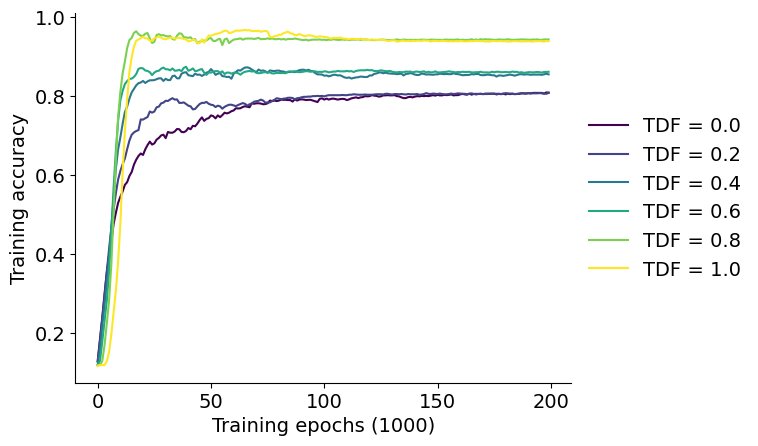

In [10]:
# training_accuracy_by_tdf = df_tdf[(df_tdf["pretrained"] == True) & (df_tdf["eta"] == 0.01)].groupby("temporal_discount_factor")["training_accuracy"].mean()
df_tdf_filtered = df_tdf[df_tdf["accuracy"] > 0.7]
training_accuracy_by_tdf = df_tdf_filtered.groupby("temporal_discount_factor")["training_accuracy"].mean()

colors = plt.cm.viridis(np.linspace(0, 1, len(training_accuracy_by_tdf)))
for i, (tdf, acc) in enumerate(training_accuracy_by_tdf.items()):
    plt.plot(acc[:200], label=f"TDF = {tdf:.1f}", color=colors[i])
    # std_dev = np.std(np.stack(df_tdf_filtered[df_tdf_filtered["temporal_discount_factor"] == tdf]["training_accuracy"]), axis=0)
    # plt.fill_between(range(len(acc[:200])), acc[:200] - std_dev, acc[:200] + std_dev, color=colors[i], alpha=0.2)
    
# set the legend to the right of the plot
ax = plt.gca()
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
plt.xlabel("Training epochs (1000)")
plt.ylabel("Training accuracy")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()


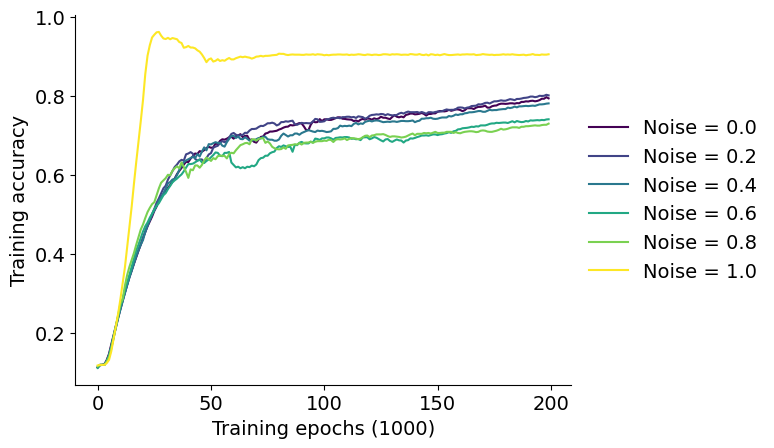

In [11]:
df_noise_filtered = df_noise[df_noise["accuracy"] > 0.7]
training_accuracy_by_noise = df_noise_filtered.groupby("noise_level")["training_accuracy"].mean()

colors = plt.cm.viridis(np.linspace(0, 1, len(training_accuracy_by_noise)))
for i, (noise, acc) in enumerate(training_accuracy_by_noise.items()):
    plt.plot(acc[:200], label=f"Noise = {noise:.1f}", color=colors[i])
    # std_dev = np.std(np.stack(df_noise_filtered[df_noise_filtered["noise_level"] == noise]["training_accuracy"]), axis=0)
    # plt.fill_between(range(len(acc[:200])), acc[:200] - std_dev, acc[:200] + std_dev, color=colors[i], alpha=0.2)

# set the legend to the right of the plot
ax = plt.gca()
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
plt.xlabel("Training epochs (1000)")
plt.ylabel("Training accuracy")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

### influencing parameters of strategy

In [12]:
df_tdf_filtered = df_tdf[df_tdf["accuracy"] > 0.7]

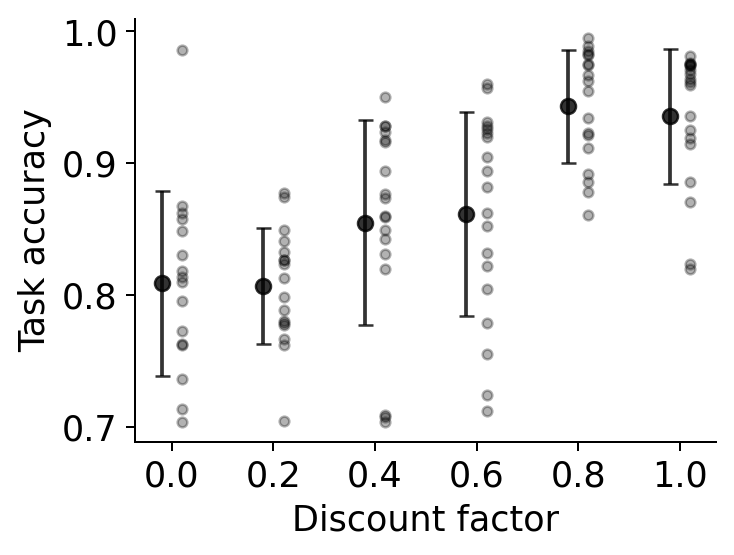

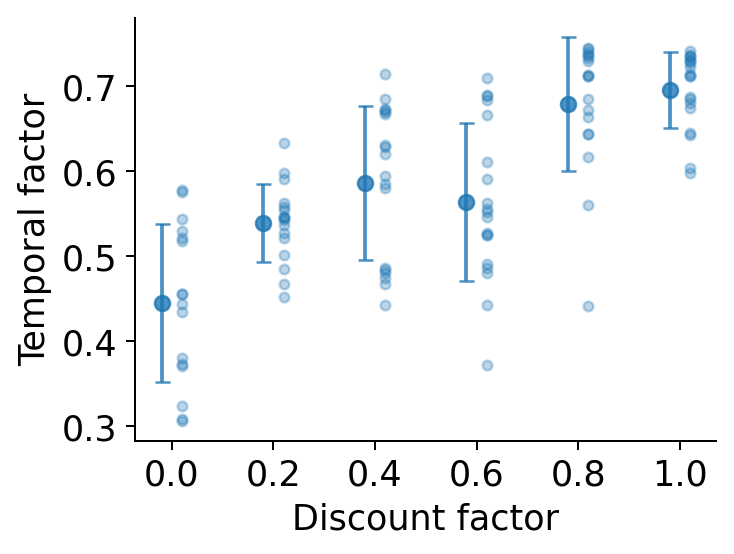

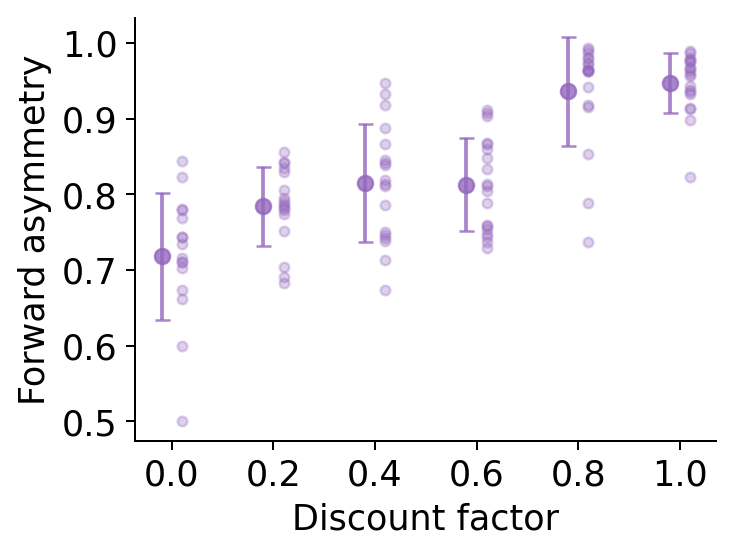

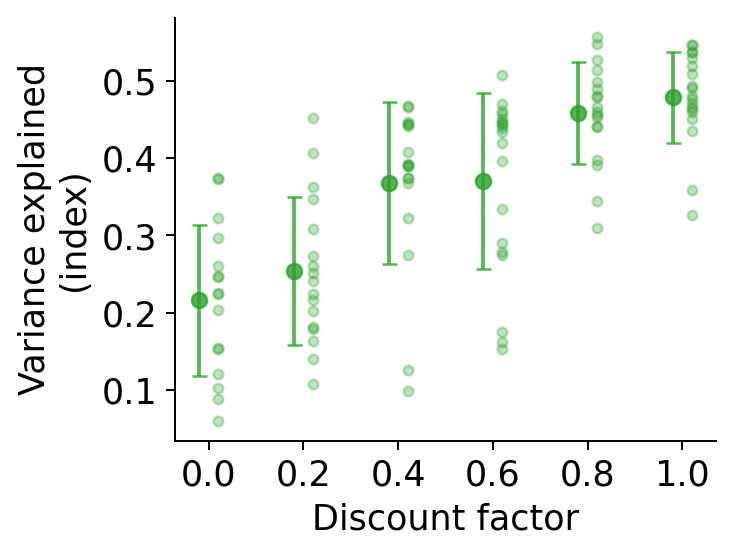

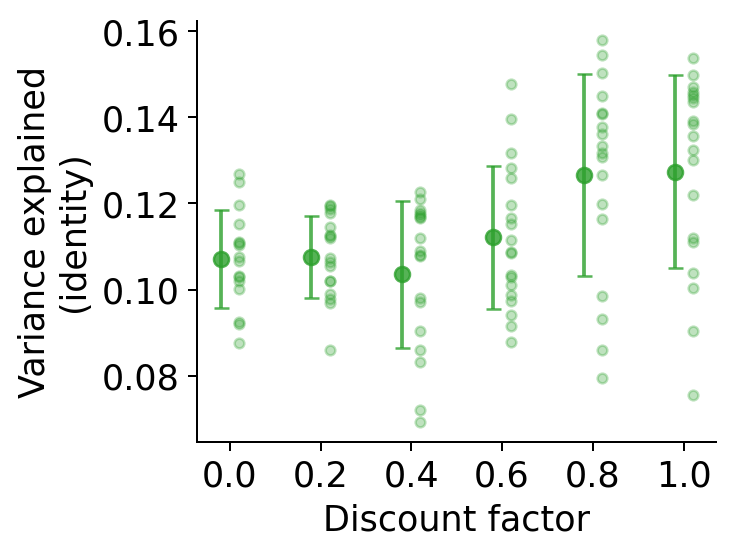

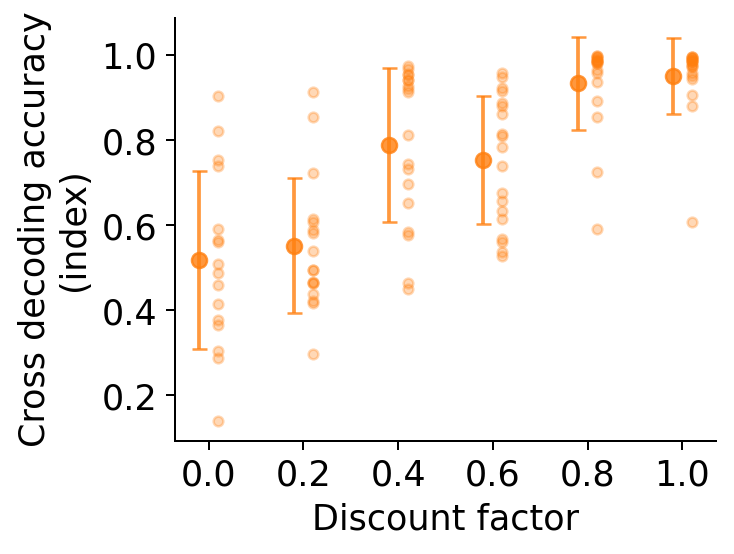

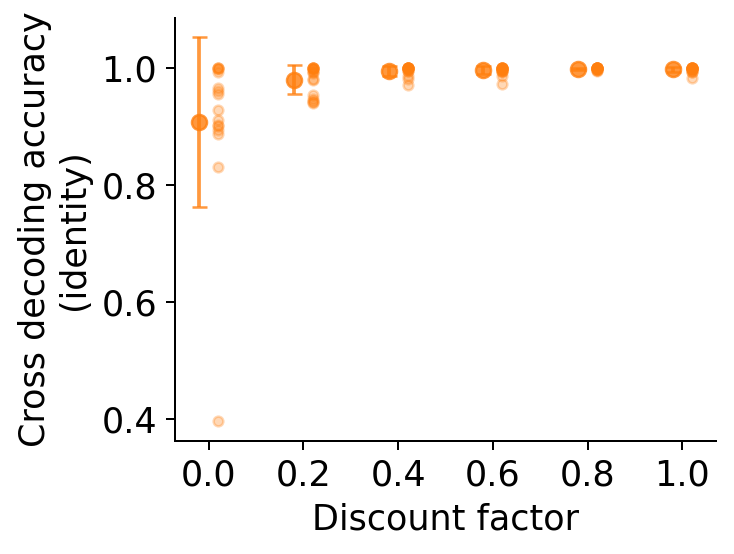

In [13]:
accuracy_mean_by_tdf = df_tdf_filtered.groupby("temporal_discount_factor")["accuracy"].mean()
accuracy_std_by_tdf = df_tdf_filtered.groupby("temporal_discount_factor")["accuracy"].std()

temporal_factor_mean_by_tdf = df_tdf_filtered.groupby("temporal_discount_factor")["temporal_factor"].mean()
temporal_factor_std_by_tdf = df_tdf_filtered.groupby("temporal_discount_factor")["temporal_factor"].std()

forward_asymmetry_mean_by_tdf = df_tdf_filtered.groupby("temporal_discount_factor")["forward_asymmetry"].mean()
forward_asymmetry_std_by_tdf = df_tdf_filtered.groupby("temporal_discount_factor")["forward_asymmetry"].std()

tdf_all = df_tdf_filtered["temporal_discount_factor"]
accuracy_all = df_tdf_filtered["accuracy"]
forward_asymmetry_all = df_tdf_filtered["forward_asymmetry"]
temporal_factor_all = df_tdf_filtered["temporal_factor"]
temporal_discount_factors = df_tdf_filtered["temporal_discount_factor"].unique()


plot_mean_std_scatter(temporal_discount_factors, accuracy_mean_by_tdf, accuracy_std_by_tdf, tdf_all, accuracy_all, "Discount factor", "Task accuracy", color=colormap["accuracy"])
plot_mean_std_scatter(temporal_discount_factors, temporal_factor_mean_by_tdf, temporal_factor_std_by_tdf, tdf_all, temporal_factor_all, "Discount factor", "Temporal factor", color=colormap["temporal_factor"])
plot_mean_std_scatter(temporal_discount_factors, forward_asymmetry_mean_by_tdf, forward_asymmetry_std_by_tdf, tdf_all, forward_asymmetry_all, "Discount factor", "Forward asymmetry", color=colormap["forward_asymmetry"])



# change with tdf
tdf_all = df_tdf_filtered["temporal_discount_factor"]
accuracy_all = df_tdf_filtered["accuracy"]
forward_asymmetry_all = df_tdf_filtered["forward_asymmetry"]
temporal_factor_all = df_tdf_filtered["temporal_factor"]
variance_explained_index_all = df_tdf_filtered["explained_variance_index"]
variance_explained_identity_all = df_tdf_filtered["explained_variance_identity"]
cross_decoding_accuracy_index_all = df_tdf_filtered["cross_decoding_accuracy_index"]
cross_decoding_accuracy_identity_all = df_tdf_filtered["cross_decoding_accuracy_identity"]

variance_explained_index_mean_by_tdf = df_tdf_filtered.groupby("temporal_discount_factor")["explained_variance_index"].mean()
variance_explained_identity_mean_by_tdf = df_tdf_filtered.groupby("temporal_discount_factor")["explained_variance_identity"].mean()
cross_decoding_accuracy_index_mean_by_tdf = df_tdf_filtered.groupby("temporal_discount_factor")["cross_decoding_accuracy_index"].mean()
cross_decoding_accuracy_identity_mean_by_tdf = df_tdf_filtered.groupby("temporal_discount_factor")["cross_decoding_accuracy_identity"].mean()

variance_explained_index_std_by_tdf = df_tdf_filtered.groupby("temporal_discount_factor")["explained_variance_index"].std()
variance_explained_identity_std_by_tdf = df_tdf_filtered.groupby("temporal_discount_factor")["explained_variance_identity"].std()
cross_decoding_accuracy_index_std_by_tdf = df_tdf_filtered.groupby("temporal_discount_factor")["cross_decoding_accuracy_index"].std()
cross_decoding_accuracy_identity_std_by_tdf = df_tdf_filtered.groupby("temporal_discount_factor")["cross_decoding_accuracy_identity"].std()


plot_mean_std_scatter(temporal_discount_factors, variance_explained_index_mean_by_tdf, variance_explained_index_std_by_tdf, 
                      tdf_all, variance_explained_index_all, "Discount factor", "Variance explained\n(index)", color=colormap["explained_variance"])

plot_mean_std_scatter(temporal_discount_factors, variance_explained_identity_mean_by_tdf, variance_explained_identity_std_by_tdf, 
                      tdf_all, variance_explained_identity_all, "Discount factor", "Variance explained\n(identity)", color=colormap["explained_variance"])

plot_mean_std_scatter(temporal_discount_factors, cross_decoding_accuracy_index_mean_by_tdf, cross_decoding_accuracy_index_std_by_tdf, 
                      tdf_all, cross_decoding_accuracy_index_all, "Discount factor", "Cross decoding accuracy\n(index)", color=colormap["cross_decoding"])

plot_mean_std_scatter(temporal_discount_factors, cross_decoding_accuracy_identity_mean_by_tdf, cross_decoding_accuracy_identity_std_by_tdf, 
                      tdf_all, cross_decoding_accuracy_identity_all, "Discount factor", "Cross decoding accuracy\n(identity)", color=colormap["cross_decoding"])


In [14]:
df_noise_filtered =  df_noise[df_noise["accuracy"] > 0.7]

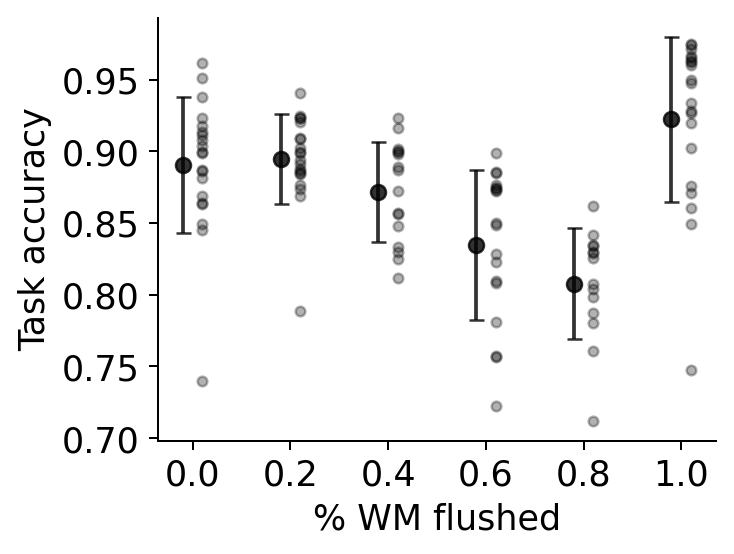

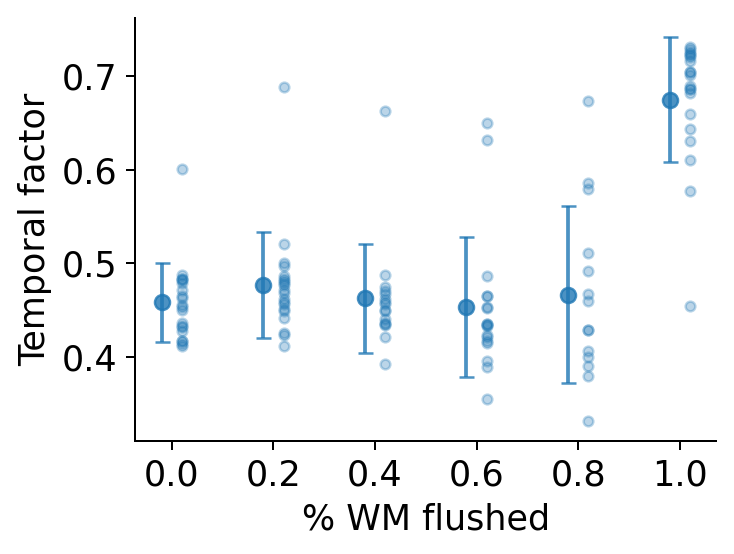

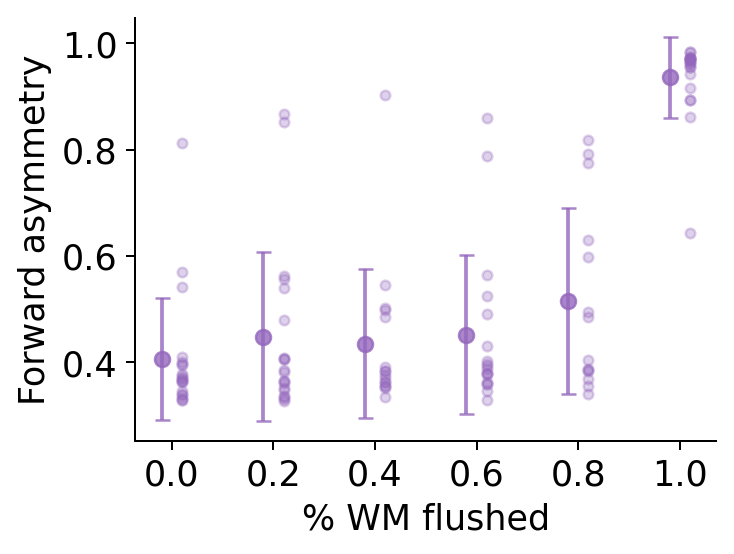

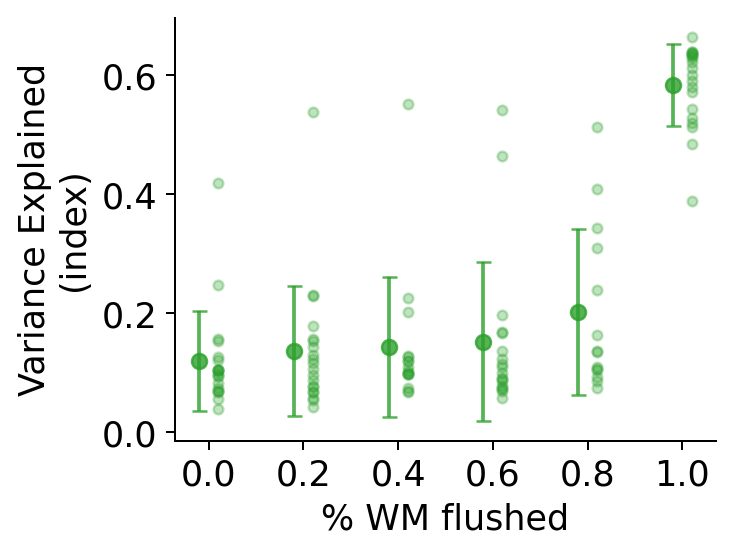

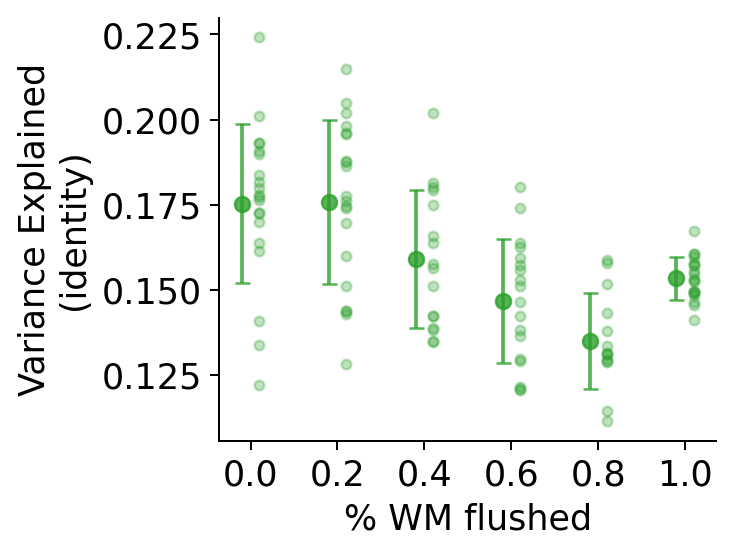

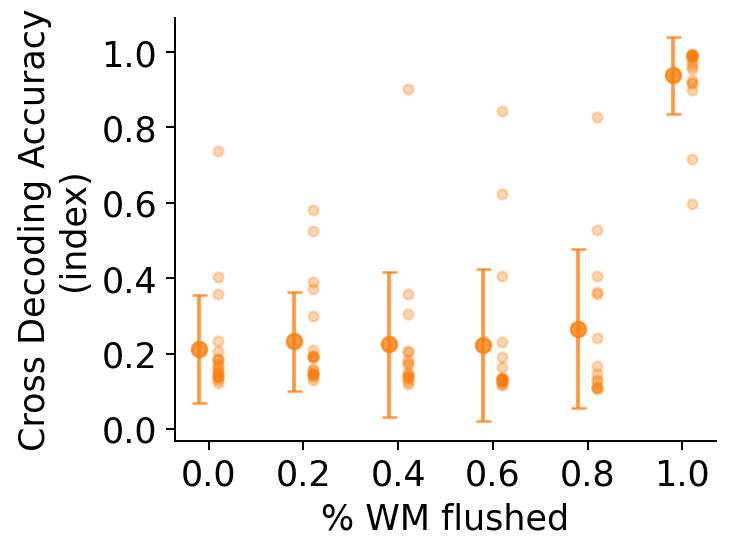

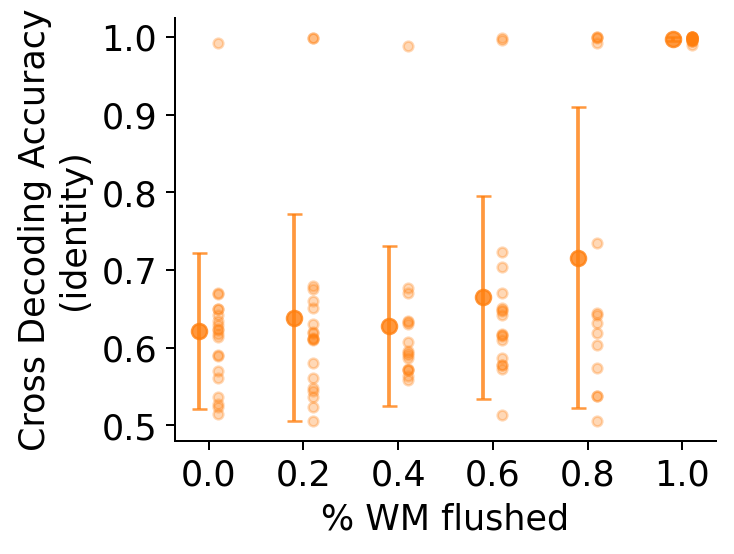

In [15]:
accuracy_mean_by_noise = df_noise_filtered.groupby("noise_level")["accuracy"].mean()
accuracy_std_by_noise = df_noise_filtered.groupby("noise_level")["accuracy"].std()

temporal_factor_mean_by_noise = df_noise_filtered.groupby("noise_level")["temporal_factor"].mean()
temporal_factor_std_by_noise = df_noise_filtered.groupby("noise_level")["temporal_factor"].std()

forward_asymmetry_mean_by_noise = df_noise_filtered.groupby("noise_level")["forward_asymmetry"].mean()
forward_asymmetry_std_by_noise = df_noise_filtered.groupby("noise_level")["forward_asymmetry"].std()

noise_all = df_noise_filtered["noise_level"]
accuracy_all = df_noise_filtered["accuracy"]
forward_asymmetry_all = df_noise_filtered["forward_asymmetry"]
temporal_factor_all = df_noise_filtered["temporal_factor"]
noise_levels = df_noise_filtered["noise_level"].unique()


plot_mean_std_scatter(temporal_discount_factors, accuracy_mean_by_noise, accuracy_std_by_noise, noise_all, accuracy_all, "% WM flushed", "Task accuracy", color=colormap['accuracy'])
plot_mean_std_scatter(temporal_discount_factors, temporal_factor_mean_by_noise, temporal_factor_std_by_noise, noise_all, temporal_factor_all, "% WM flushed", "Temporal factor", color=colormap["temporal_factor"])
plot_mean_std_scatter(temporal_discount_factors, forward_asymmetry_mean_by_noise, forward_asymmetry_std_by_noise, noise_all, forward_asymmetry_all, "% WM flushed", "Forward asymmetry", color=colormap["forward_asymmetry"])



variance_explained_index_all = df_noise_filtered["explained_variance_index"]
variance_explained_identity_all = df_noise_filtered["explained_variance_identity"]
cross_decoding_accuracy_index_all = df_noise_filtered["cross_decoding_accuracy_index"]
cross_decoding_accuracy_identity_all = df_noise_filtered["cross_decoding_accuracy_identity"]

variance_explained_index_mean_by_noise = df_noise_filtered.groupby("noise_level")["explained_variance_index"].mean()
variance_explained_index_std_by_noise = df_noise_filtered.groupby("noise_level")["explained_variance_index"].std()
variance_explained_identity_mean_by_noise = df_noise_filtered.groupby("noise_level")["explained_variance_identity"].mean()
variance_explained_identity_std_by_noise = df_noise_filtered.groupby("noise_level")["explained_variance_identity"].std()

cross_decoding_accuracy_index_mean_by_noise = df_noise_filtered.groupby("noise_level")["cross_decoding_accuracy_index"].mean()
cross_decoding_accuracy_index_std_by_noise = df_noise_filtered.groupby("noise_level")["cross_decoding_accuracy_index"].std()
cross_decoding_accuracy_identity_mean_by_noise = df_noise_filtered.groupby("noise_level")["cross_decoding_accuracy_identity"].mean()
cross_decoding_accuracy_identity_std_by_noise = df_noise_filtered.groupby("noise_level")["cross_decoding_accuracy_identity"].std()


plot_mean_std_scatter(noise_levels, variance_explained_index_mean_by_noise, variance_explained_index_std_by_noise, noise_all, variance_explained_index_all, "% WM flushed", "Variance Explained\n(index)", colormap["explained_variance"])
plot_mean_std_scatter(noise_levels, variance_explained_identity_mean_by_noise, variance_explained_identity_std_by_noise, noise_all, variance_explained_identity_all, "% WM flushed", "Variance Explained\n(identity)", colormap["explained_variance"])
plot_mean_std_scatter(noise_levels, cross_decoding_accuracy_index_mean_by_noise, cross_decoding_accuracy_index_std_by_noise, noise_all, cross_decoding_accuracy_index_all, "% WM flushed", "Cross Decoding Accuracy\n(index)", colormap["cross_decoding"])
plot_mean_std_scatter(noise_levels, cross_decoding_accuracy_identity_mean_by_noise, cross_decoding_accuracy_identity_std_by_noise, noise_all, cross_decoding_accuracy_identity_all, "% WM flushed", "Cross Decoding Accuracy\n(identity)", colormap["cross_decoding"])


### Clustering

In [16]:
# df_all_filtered = df_all[(df_all["accuracy"]>0.7)]
df_all_filtered = df_all[(df_all["accuracy"]>0.7) & (df_all["temporal_factor"] >= 0.4)]
print(len(df_all_filtered))

200


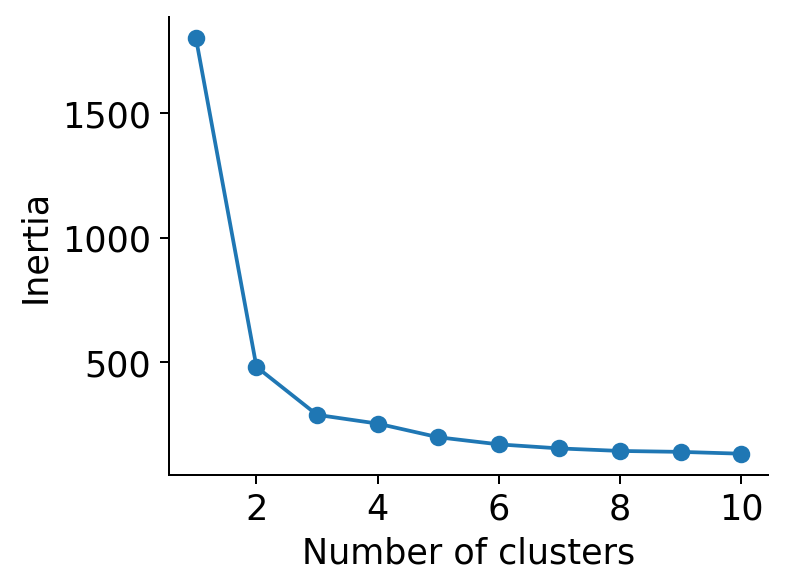

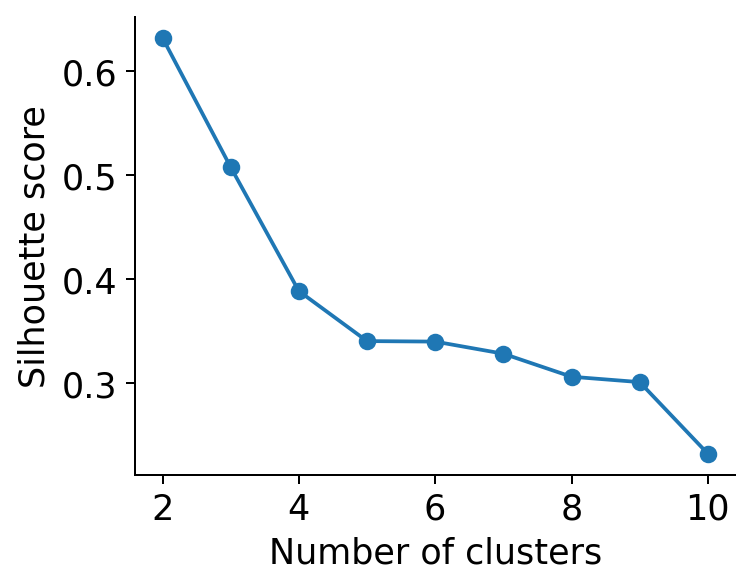

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

features = ["forward_asymmetry", "temporal_factor",
            "index_decoding_accuracy", "item_decoding_accuracy", "last_item_decoding_accuracy", 
            "explained_variance_index", "explained_variance_identity", 
            "cross_decoding_accuracy_index", "cross_decoding_accuracy_identity"]

X = df_all_filtered[features]

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Determine the optimal number of clusters with elbow method
inertia = []
sihoutte_score = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_normalized)
    labels = kmeans.labels_
    inertia.append(kmeans.inertia_)
    if n_clusters > 1:
        sihoutte_score.append(silhouette_score(X_normalized, labels))

plt.figure(figsize=(4.3, 3.3), dpi=180)
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.title('Inertia for Optimal Number of Clusters')
plt.show()

plt.figure(figsize=(4.3, 3.3), dpi=180)
plt.plot(range(2, 11), sihoutte_score, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [18]:
# make the optimal number of clusters\

# Fit the KMeans model with the optimal number of clusters
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_normalized)
df_all_filtered.loc[:, 'cluster'] = cluster_labels

# Add silhouette score to evaluate clustering quality
silhouette_avg = silhouette_score(X_normalized, cluster_labels)
print(f'Silhouette Score for {optimal_clusters} clusters: {silhouette_avg}')



Silhouette Score for 3 clusters: 0.5074778850837416


/state/partition1/job-61319506/ipykernel_618811/2963582835.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_filtered.loc[:, 'cluster'] = cluster_labels


In [19]:
# print 5 info for each cluster
for i in range(optimal_clusters):
    print(f'Cluster {i+1}:')
    print(df_all_filtered[df_all_filtered['cluster'] == i][["temporal_discount_factor", "noise_level", "model_num"]].head())

Cluster 1:


    temporal_discount_factor  noise_level  model_num
4                        0.0          1.0          4
23                       0.2          1.0          3
32                       0.2          1.0         12
40                       0.4          1.0          0
41                       0.4          1.0          1
Cluster 2:
     temporal_discount_factor  noise_level  model_num
120                       1.0          0.0          0
121                       1.0          0.0          1
122                       1.0          0.0          2
123                       1.0          0.0          3
124                       1.0          0.0          4
Cluster 3:
    temporal_discount_factor  noise_level  model_num
2                        0.0          1.0          2
3                        0.0          1.0          3
5                        0.0          1.0          5
6                        0.0          1.0          6
10                       0.0          1.0         10


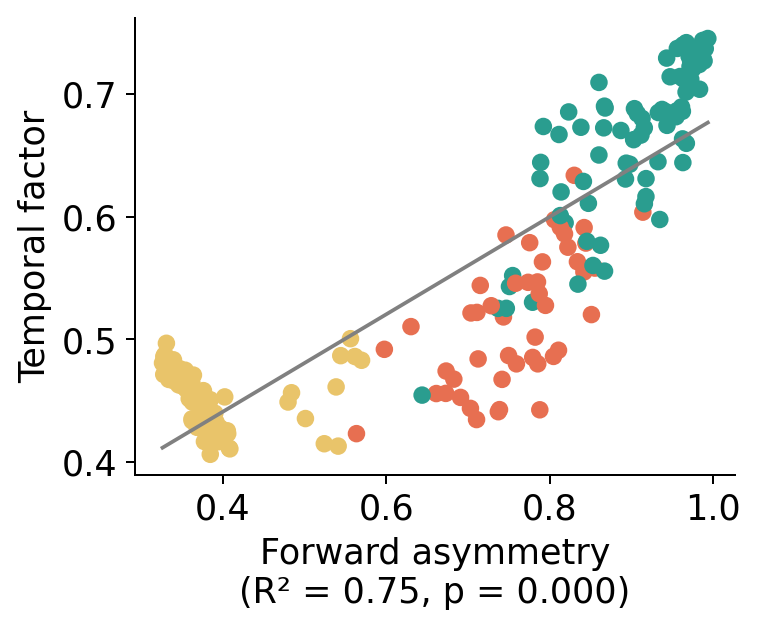

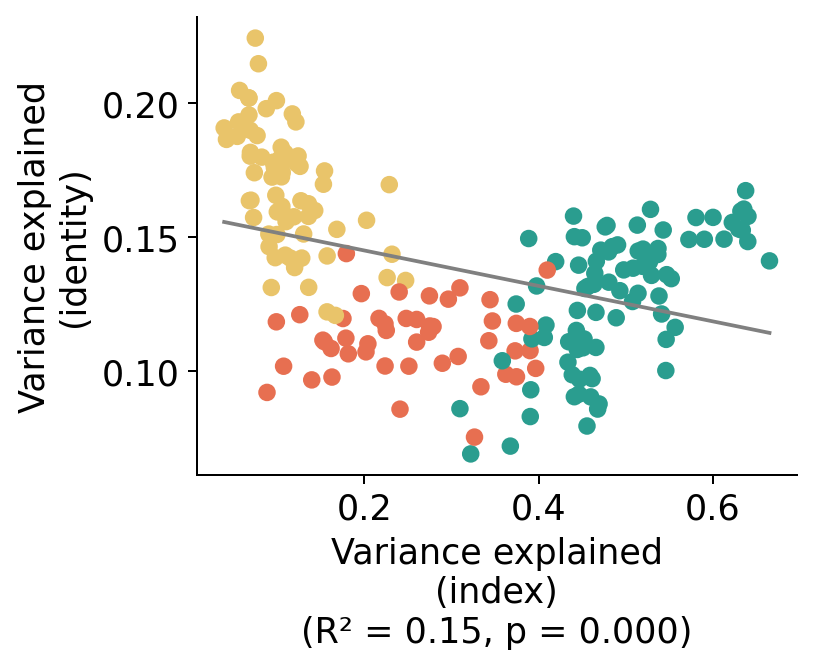

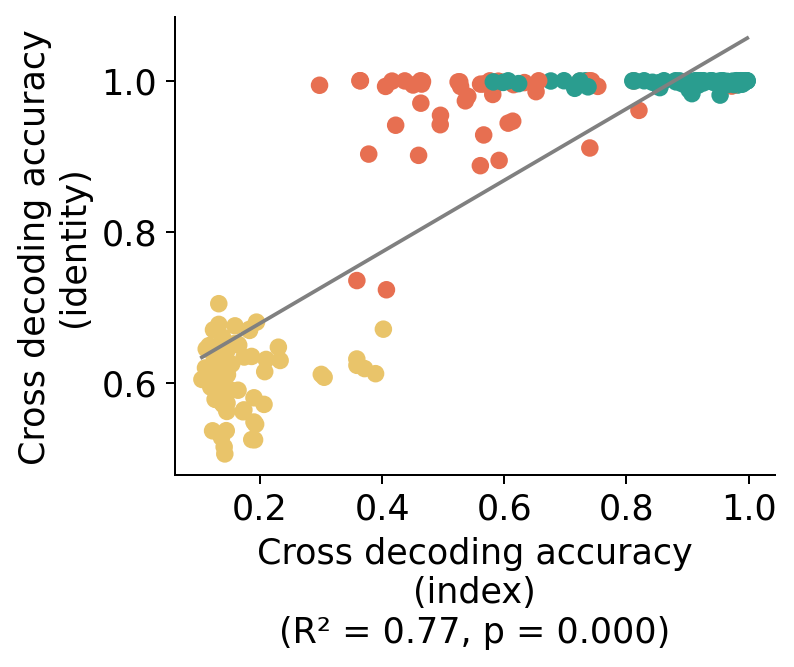

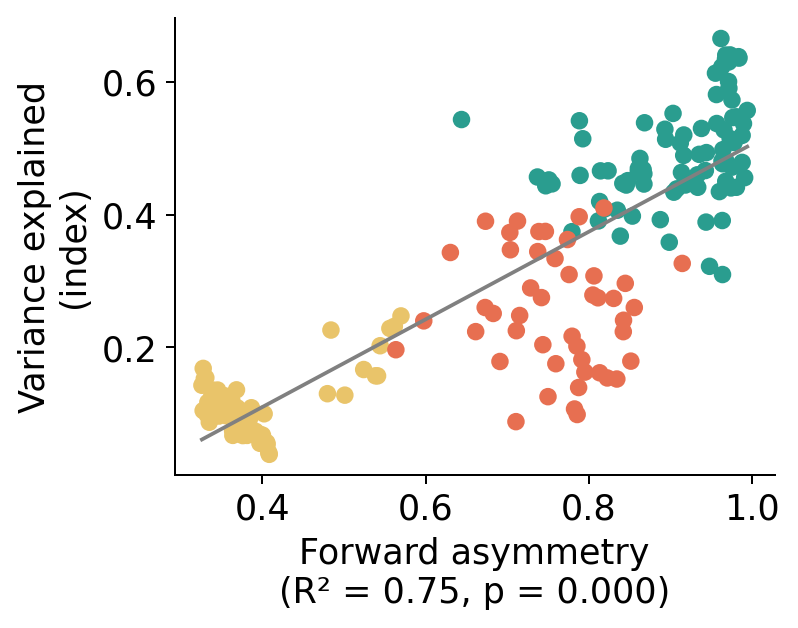

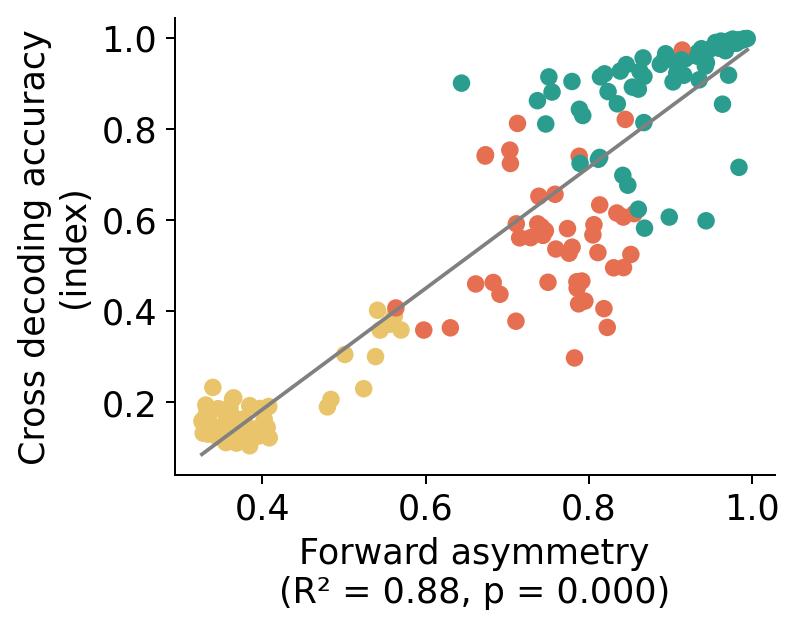

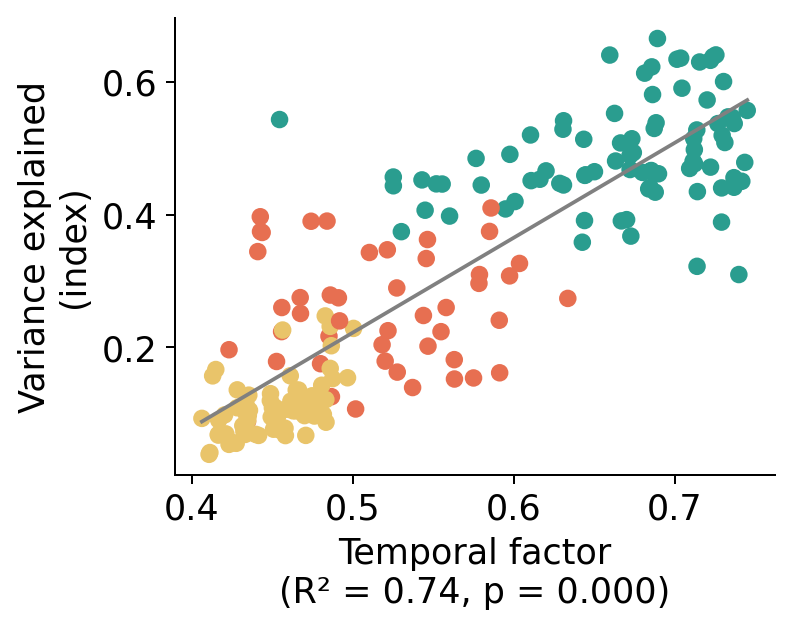

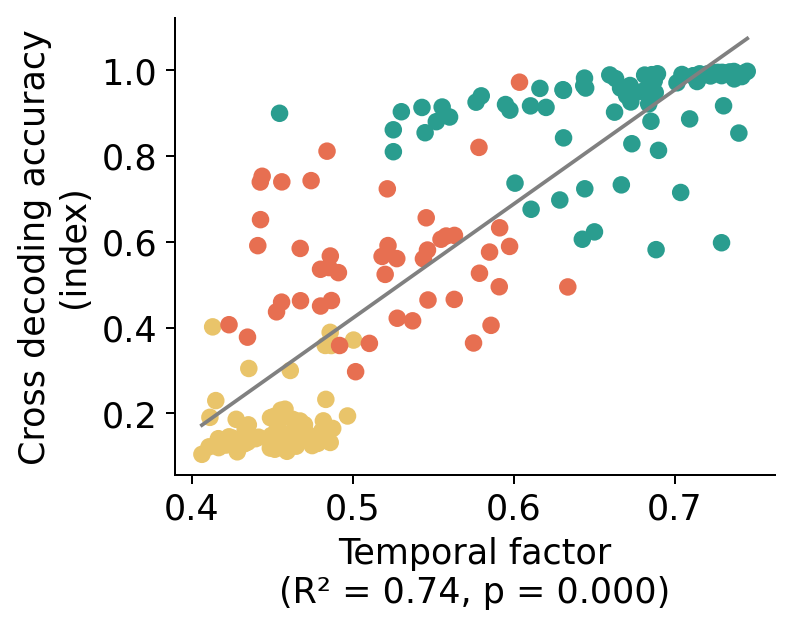

In [20]:
# plot scatter with cluster labels
colormap = np.array(["#2A9D8F", "#E9C46A", "#E76F51", "#F4A261", "#264653"])

def plot_scatter_cluster(df, x, y, c, x_label, y_label):
    plt.figure(figsize=(4.3, 3.3), dpi=180)

    plt.scatter(df[x], df[y], c=colormap[df[c].iloc[:]])

    # Reshape x and y for sklearn
    x_reshaped = np.array(df[x]).reshape(-1, 1)
    y_reshaped = np.array(df[y]).reshape(-1, 1)

    # Fit linear regression model
    model = LinearRegression()
    model.fit(x_reshaped, y_reshaped)

    # Predict y values
    sorted_x_idx = np.argsort(x_reshaped.reshape(-1))
    x1, x2 = x_reshaped[sorted_x_idx[0]], x_reshaped[sorted_x_idx[-1]]
    y_pred = model.predict(x_reshaped)
    y1, y2 = y_pred[sorted_x_idx[0]], y_pred[sorted_x_idx[-1]]

    # Calculate R-squared
    r2 = r2_score(y_reshaped, y_pred)
    # Calculate the p-value for the regression
    _, p_value = stats.pearsonr(x_reshaped.flatten(), y_reshaped.flatten())
    
    # Plot the regression line
    plt.plot([x1, x2], [y1, y2], color="grey")

    plt.xlabel(x_label+"\n(R² = {:.2f}, p = {:.3f})".format(r2, p_value))
    plt.ylabel(y_label)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.tight_layout()
    plt.show()

plot_scatter_cluster(df_all_filtered, 'forward_asymmetry', 'temporal_factor', 'cluster', 'Forward asymmetry', 'Temporal factor')
plot_scatter_cluster(df_all_filtered, 'explained_variance_index', 'explained_variance_identity', 'cluster', 'Variance explained\n(index)', 'Variance explained\n(identity)')
plot_scatter_cluster(df_all_filtered, 'cross_decoding_accuracy_index', 'cross_decoding_accuracy_identity', 'cluster', 'Cross decoding accuracy\n(index)', 'Cross decoding accuracy\n(identity)')

plot_scatter_cluster(df_all_filtered, 'forward_asymmetry', 'explained_variance_index', 'cluster', 'Forward asymmetry', 'Variance explained\n(index)')
plot_scatter_cluster(df_all_filtered, 'forward_asymmetry', 'cross_decoding_accuracy_index', 'cluster', 'Forward asymmetry', 'Cross decoding accuracy\n(index)')

plot_scatter_cluster(df_all_filtered, 'temporal_factor', 'explained_variance_index', 'cluster', 'Temporal factor', 'Variance explained\n(index)')
plot_scatter_cluster(df_all_filtered, 'temporal_factor', 'cross_decoding_accuracy_index', 'cluster', 'Temporal factor', 'Cross decoding accuracy\n(index)')


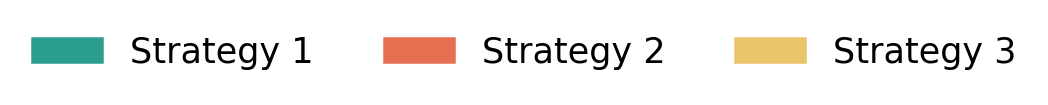

In [21]:
# Create a legend for the colormap
import matplotlib.patches as mpatches

# Define labels for the legend
legend_labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']

# Create a list of patches for the legend
patches = [mpatches.Patch(color="#2A9D8F", label="Strategy 1"),
           mpatches.Patch(color="#E76F51", label="Strategy 2"),
           mpatches.Patch(color="#E9C46A", label="Strategy 3")]
# [mpatches.Patch(color=colormap[i], label=legend_labels[i]) for i in range(optimal_clusters)]

# Plot the legend
plt.figure(figsize=(4.3, 0.5), dpi=180)
plt.legend(handles=patches, loc='center', ncol=optimal_clusters, frameon=False)
plt.axis('off')
plt.show()

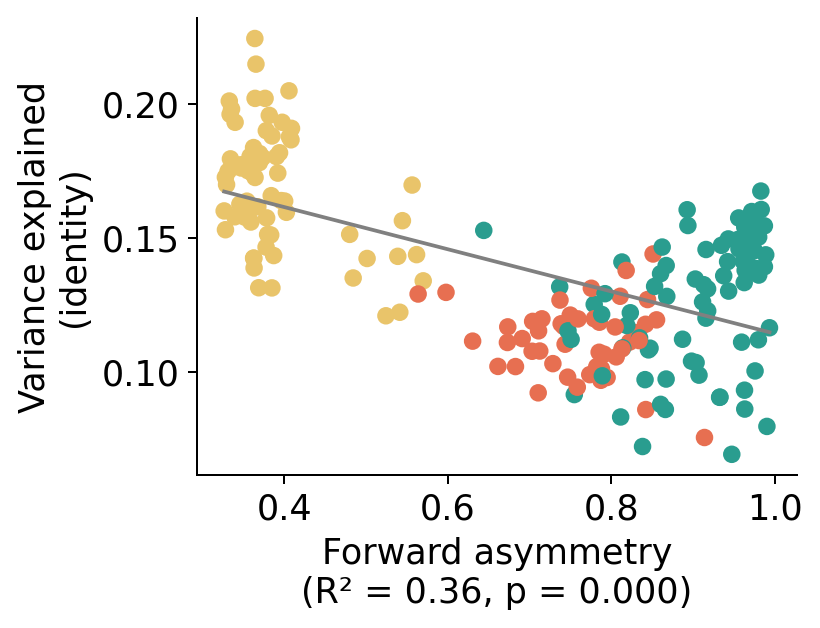

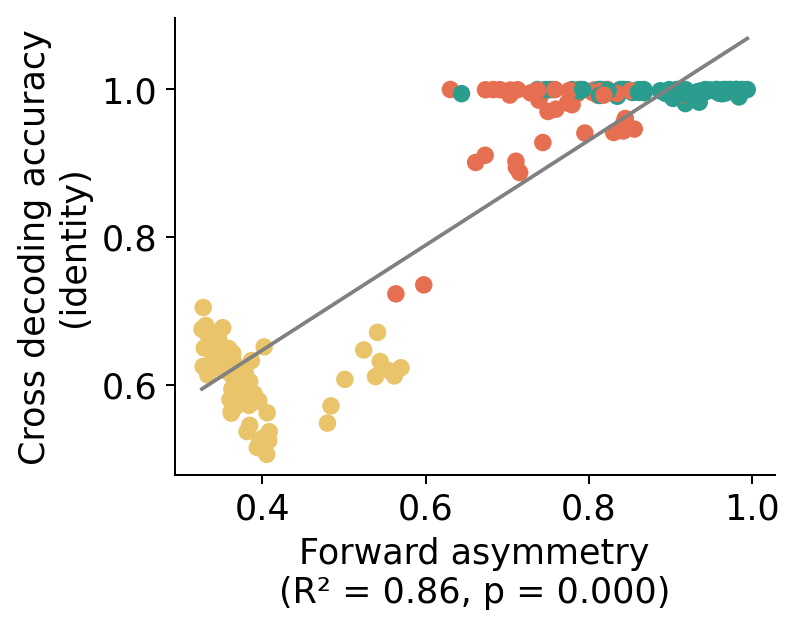

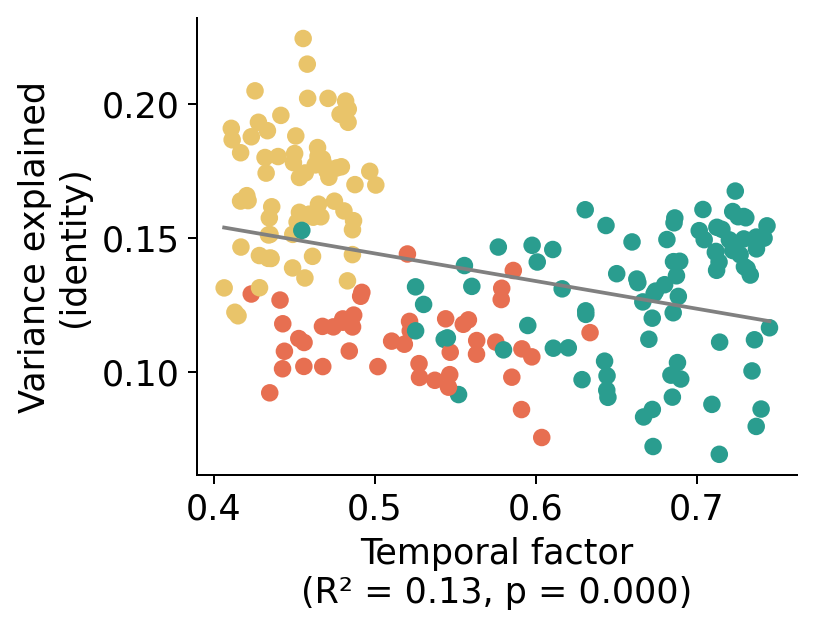

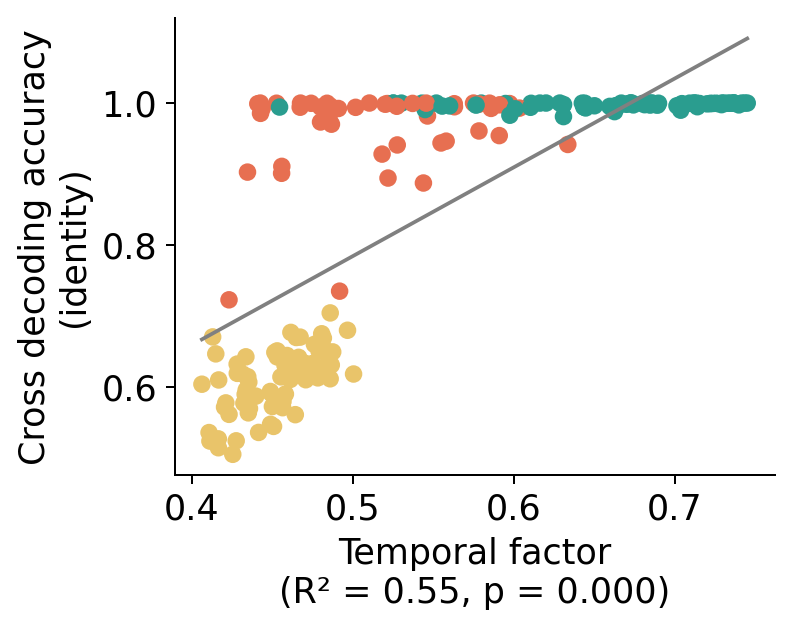

In [22]:

plot_scatter_cluster(df_all_filtered, 'forward_asymmetry', 'explained_variance_identity', 'cluster', 'Forward asymmetry', 'Variance explained\n(identity)')
plot_scatter_cluster(df_all_filtered, 'forward_asymmetry', 'cross_decoding_accuracy_identity', 'cluster', 'Forward asymmetry', 'Cross decoding accuracy\n(identity)')

plot_scatter_cluster(df_all_filtered, 'temporal_factor', 'explained_variance_identity', 'cluster', 'Temporal factor', 'Variance explained\n(identity)')
plot_scatter_cluster(df_all_filtered, 'temporal_factor', 'cross_decoding_accuracy_identity', 'cluster', 'Temporal factor', 'Cross decoding accuracy\n(identity)')

WCSS Contribution of each dimension:
forward asymmetry: 0.0594
temporal factor: 0.1487
index decoding accuracy: 0.0732
item decoding accuracy: 0.0896
last item decoding accuracy: 0.1062
explained variance index: 0.1039
explained variance identity: 0.3242
cross decoding accuracy index: 0.0636
cross decoding accuracy identity: 0.0313


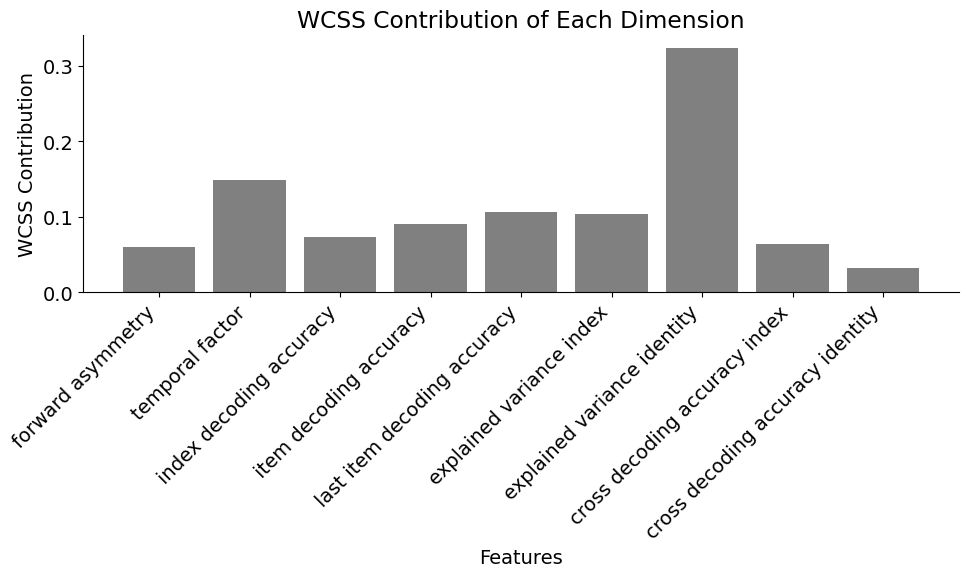

In [23]:
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np

# Calculate the contribution of each dimension to the clustering
def calculate_wcss_contribution(df, data, features, cluster_centers):
    # Initialize a dictionary to store WCSS contribution for each feature
    wcss_contribution = {feature.replace('_', ' '): 0 for feature in features}
    
    # Iterate over each cluster
    for i in range(optimal_clusters):
        # Get data points in the current cluster
        # cluster_data = df[df['cluster'] == i][features]
        cluster_data = data[df['cluster'] == i]
        
        # Calculate the distance of each point to the cluster center
        _, distances = pairwise_distances_argmin_min(cluster_data, [cluster_centers[i]])
        
        # Calculate the WCSS for each feature
        for j, feature in enumerate(features):
            feature_values = cluster_data[:, j]
            feature_center = cluster_centers[i][j]
            wcss_contribution[feature.replace('_', ' ')] += np.sum((feature_values - feature_center) ** 2)
    
    # Normalize the contributions to sum to 1
    total_wcss = sum(wcss_contribution.values())
    for feature in wcss_contribution:
        wcss_contribution[feature.replace('_', ' ')] /= total_wcss
    
    return wcss_contribution

# Define the features used for clustering
# features = ['forward_asymmetry', 'temporal_factor', 'explained_variance_index', 
#             'explained_variance_identity', 'cross_decoding_accuracy_index', 
#             'cross_decoding_accuracy_identity']

# Assuming cluster_centers is a list of cluster centers obtained from the clustering algorithm
cluster_centers = kmeans.cluster_centers_

X = df_all_filtered[features]

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Calculate WCSS contribution
wcss_contribution = calculate_wcss_contribution(df_all_filtered, X_normalized, features, cluster_centers)

# Print the contribution of each dimension
print("WCSS Contribution of each dimension:")
for feature, contribution in wcss_contribution.items():
    print(f"{feature}: {contribution:.4f}")

# Create a bar plot for the WCSS contribution of each dimension
plt.figure(figsize=(10, 6))
plt.bar(wcss_contribution.keys(), wcss_contribution.values(), color='grey')
plt.xlabel('Features')
plt.ylabel('WCSS Contribution')
plt.title('WCSS Contribution of Each Dimension')
plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()



In [24]:
# plot_scatter_cluster(df_all_filtered, 'forward_asymmetry', 'accuracy', 'cluster', 'Forward asymmetry', 'Task accuracy')
# plot_scatter_cluster(df_all_filtered, 'temporal_factor', 'accuracy', 'cluster', 'Temporal factor', 'Task accuracy')
# plot_scatter_cluster(df_all_filtered, 'explained_variance_index', 'accuracy', 'cluster', 'Variance explained\n(index)', 'Task accuracy')
# plot_scatter_cluster(df_all_filtered, 'explained_variance_identity', 'accuracy', 'cluster', 'Variance explained\n(identity)', 'Task accuracy')
# plot_scatter_cluster(df_all_filtered, 'cross_decoding_accuracy_index', 'accuracy', 'cluster', 'Cross decoding accuracy\n(index)', 'Task accuracy')
# plot_scatter_cluster(df_all_filtered, 'cross_decoding_accuracy_identity', 'accuracy', 'cluster', 'Cross decoding accuracy\n(identity)', 'Task accuracy')

In [25]:
# distribution of strategies in each factor

def plot_bar_by_strategy(df, x, x_label):
    plt.figure(figsize=(4.3, 3.3), dpi=180)
    
    cluster_distribution = df.groupby(["cluster", x]).size().unstack(fill_value=0)
    sum_distribution = cluster_distribution.sum(axis=0)
    cluster_distribution = cluster_distribution.div(sum_distribution, axis=1)
    cumsum_distribution = cluster_distribution.cumsum(axis=0)

    for i, row in cumsum_distribution.iterrows():
        plt.bar(row.index, row.values, color=colormap[i], label=f"Cluster {i}", width=0.1, zorder=-i)
    plt.xlabel(x_label)
    plt.ylabel("Distribution of strategies")

    unique_x = df[x].unique()
    plt.xticks(unique_x, unique_x)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()


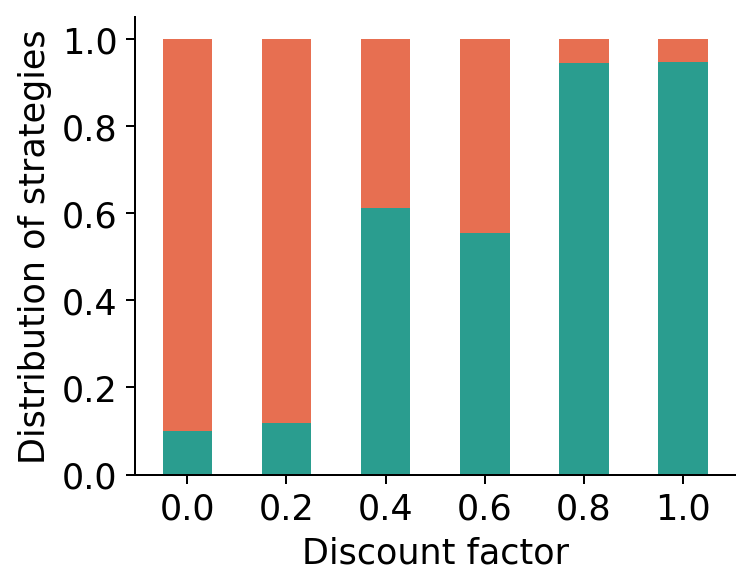

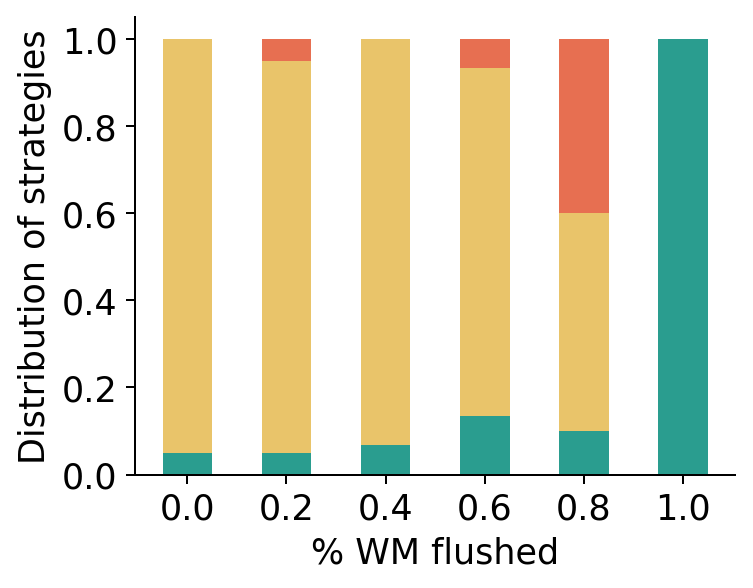

In [26]:
df_all_tdf = df_all_filtered[df_all_filtered["exp"] == "tdf"]
plot_bar_by_strategy(df_all_tdf, "temporal_discount_factor", "Discount factor")

df_all_noise = df_all_filtered[df_all_filtered["exp"] == "noise"]
plot_bar_by_strategy(df_all_noise, "noise_level", "% WM flushed")


### metrics with performance

In [27]:
colormap = {
    "forward_asymmetry": "tab:purple",
    "temporal_factor": "tab:blue",
    "explained_variance": "tab:green",
    "cross_decoding": "tab:orange",
    "accuracy": "black"
}

In [28]:
from matplotlib.colors import ListedColormap

def plot_scatter_by_group(df, x, y, c, x_label, y_label, colormap_label, colormap='viridis'):
    plt.figure(figsize=(4.3, 3.3), dpi=180)
    
    colors = plt.get_cmap(colormap)(np.linspace(0, 1, len(df[c].unique())))
    
    group_unique_values = df[c].unique()
    for i, group in enumerate(group_unique_values):
        group_data = df[df[c] == group]
        plt.scatter(group_data[x], group_data[y], color=colors[i], label=colormap_label+"="+str(group))

    # Reshape x and y for sklearn
    x_reshaped = np.array(df[x]).reshape(-1, 1)
    y_reshaped = np.array(df[y]).reshape(-1, 1)

    # Fit linear regression model
    model = LinearRegression()
    model.fit(x_reshaped, y_reshaped)

    # Predict y values
    sorted_x_idx = np.argsort(x_reshaped.reshape(-1))
    x1, x2 = x_reshaped[sorted_x_idx[0]], x_reshaped[sorted_x_idx[-1]]
    y_pred = model.predict(x_reshaped)
    y1, y2 = y_pred[sorted_x_idx[0]], y_pred[sorted_x_idx[-1]]

    # Calculate R-squared
    r2 = r2_score(y_reshaped, y_pred)
    # Calculate the p-value for the regression
    _, p_value = stats.pearsonr(x_reshaped.flatten(), y_reshaped.flatten())
    
    # Plot the regression line
    plt.plot([x1, x2], [y1, y2], color="grey")

    plt.xlabel(x_label+"\n(R² = {:.2f}, p = {:.3f})".format(r2, p_value))
    plt.ylabel(y_label)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)

    cmap = ListedColormap(colors)
    norm = plt.Normalize(vmin=np.min(group_unique_values) - 0.1, vmax=np.max(group_unique_values) + 0.1)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=group_unique_values, label=colormap_label, ax=ax)

    plt.show()

In [29]:
df_tdf_filtered = df_tdf[(df_tdf["temporal_factor"] >= 0.4)]

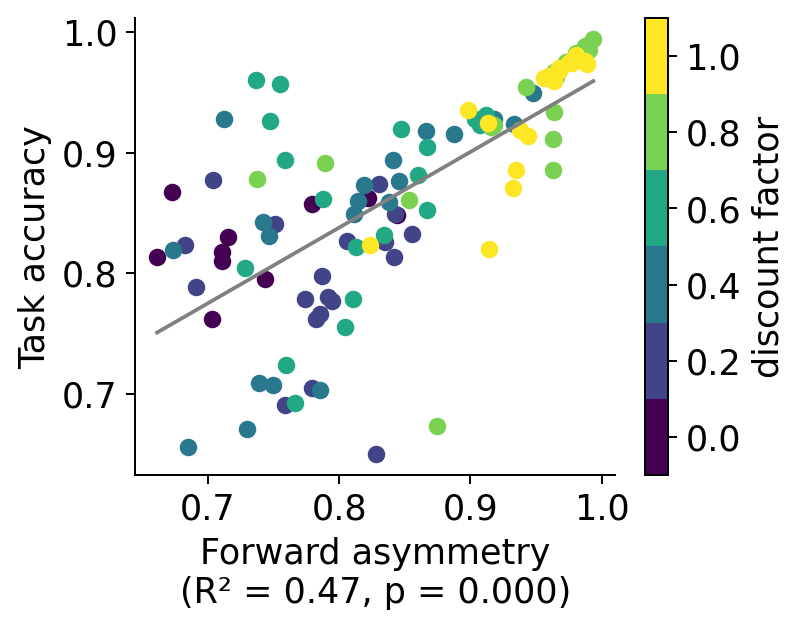

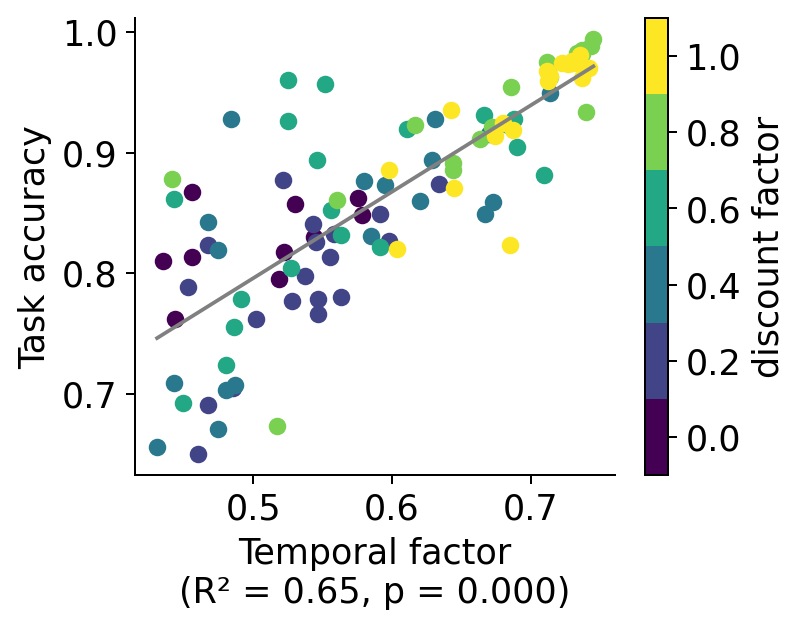

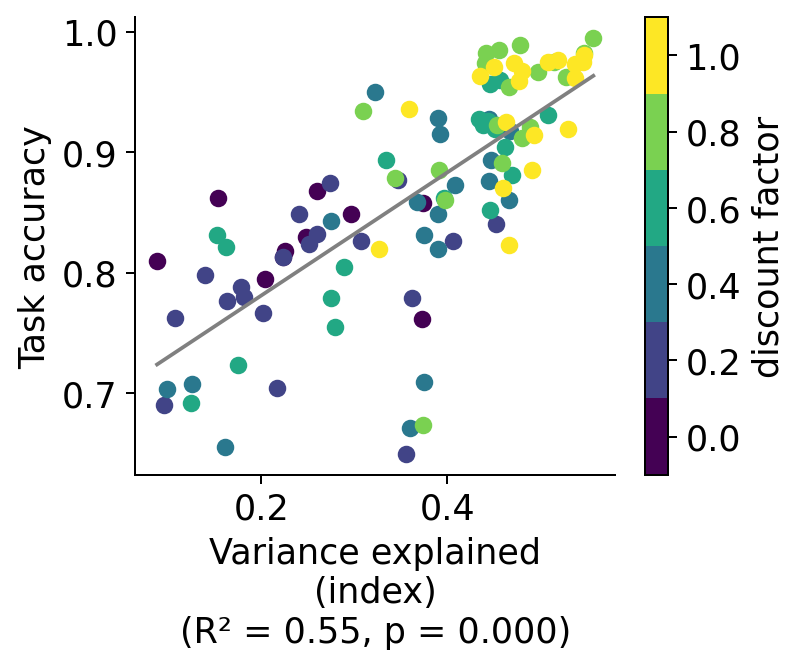

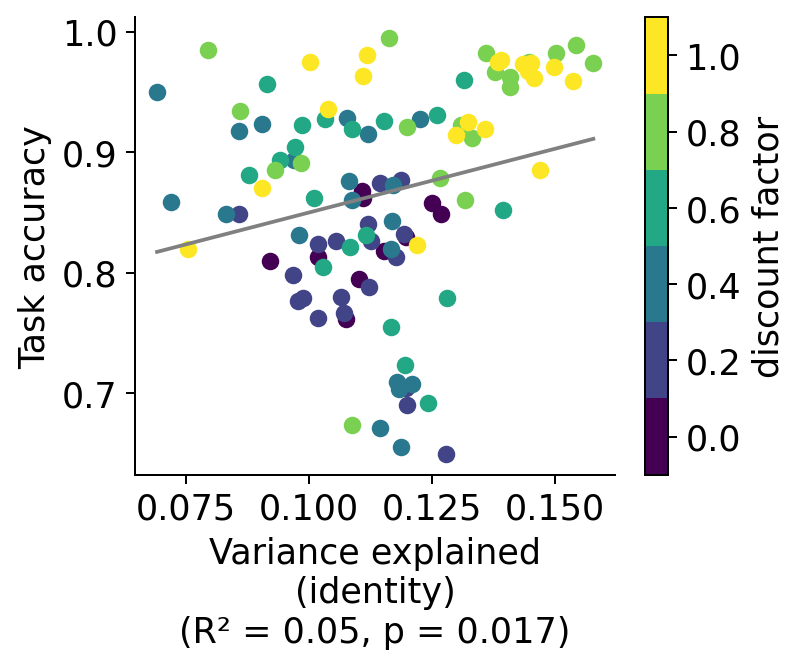

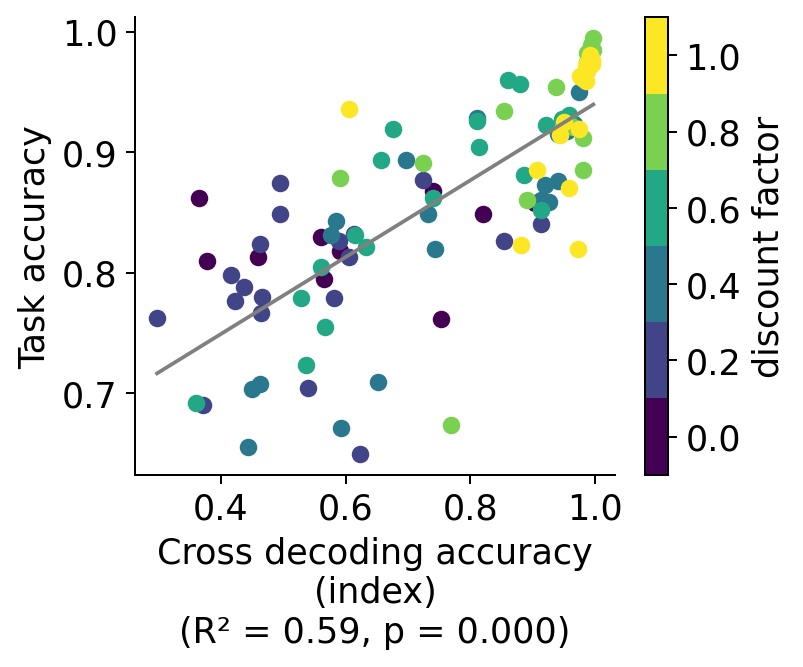

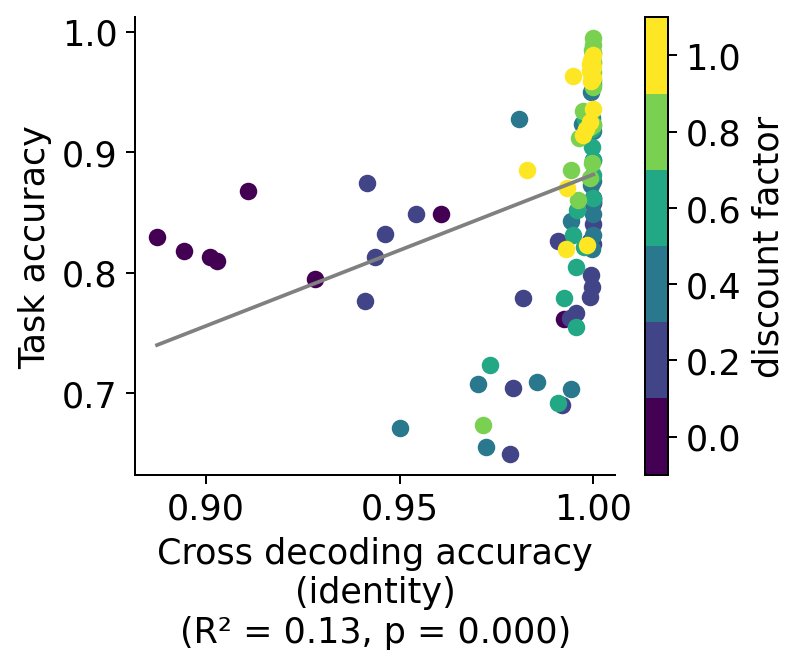

In [30]:
# metrics and accuracy
plot_scatter_by_group(df_tdf_filtered, "forward_asymmetry", "accuracy", "temporal_discount_factor", "Forward asymmetry", "Task accuracy", "discount factor")
plot_scatter_by_group(df_tdf_filtered, "temporal_factor", "accuracy", "temporal_discount_factor", "Temporal factor", "Task accuracy", "discount factor")
plot_scatter_by_group(df_tdf_filtered, "explained_variance_index", "accuracy", "temporal_discount_factor", "Variance explained\n(index)", "Task accuracy", "discount factor")
plot_scatter_by_group(df_tdf_filtered, "explained_variance_identity", "accuracy", "temporal_discount_factor", "Variance explained\n(identity)", "Task accuracy", "discount factor")
plot_scatter_by_group(df_tdf_filtered, "cross_decoding_accuracy_index", "accuracy", "temporal_discount_factor", "Cross decoding accuracy\n(index)", "Task accuracy", "discount factor")
plot_scatter_by_group(df_tdf_filtered, "cross_decoding_accuracy_identity", "accuracy", "temporal_discount_factor", "Cross decoding accuracy\n(identity)", "Task accuracy", "discount factor")


In [31]:
df_noise_filtered = df_noise[df_noise["temporal_factor"] >= 0.4]

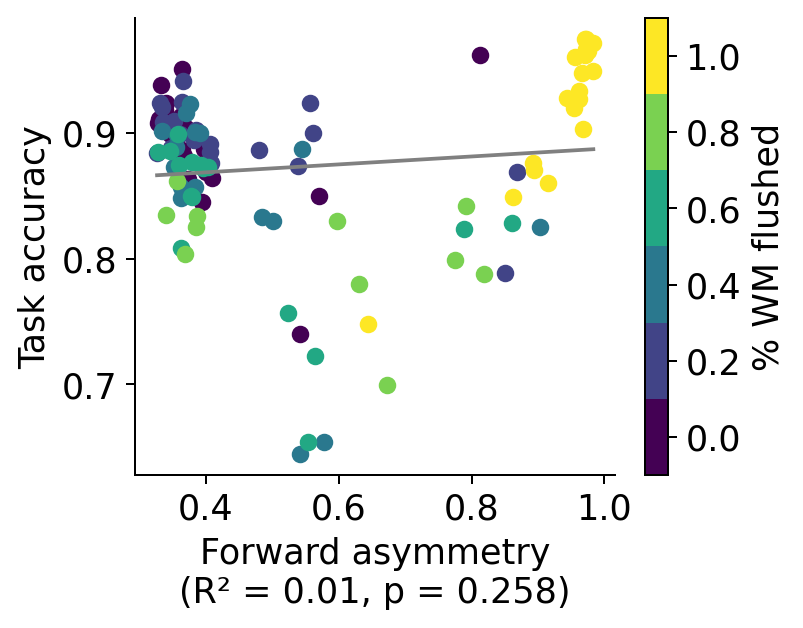

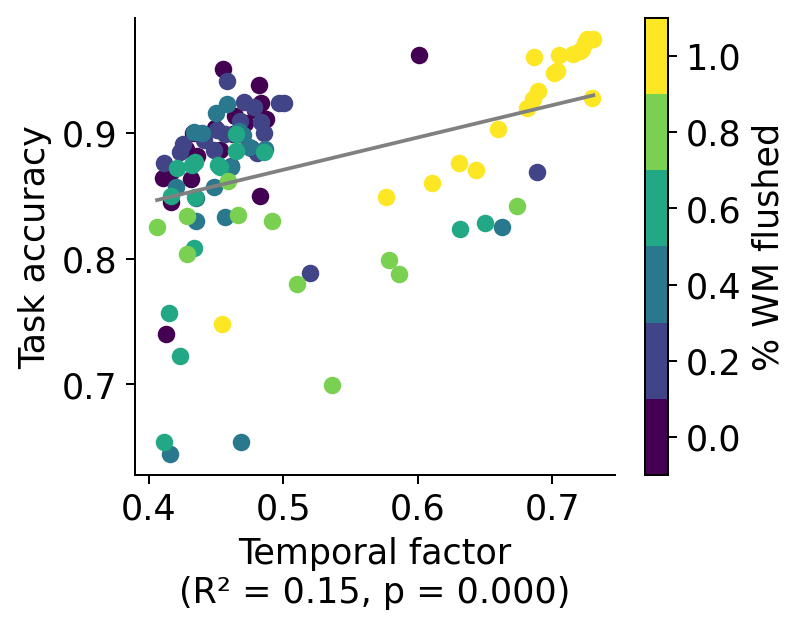

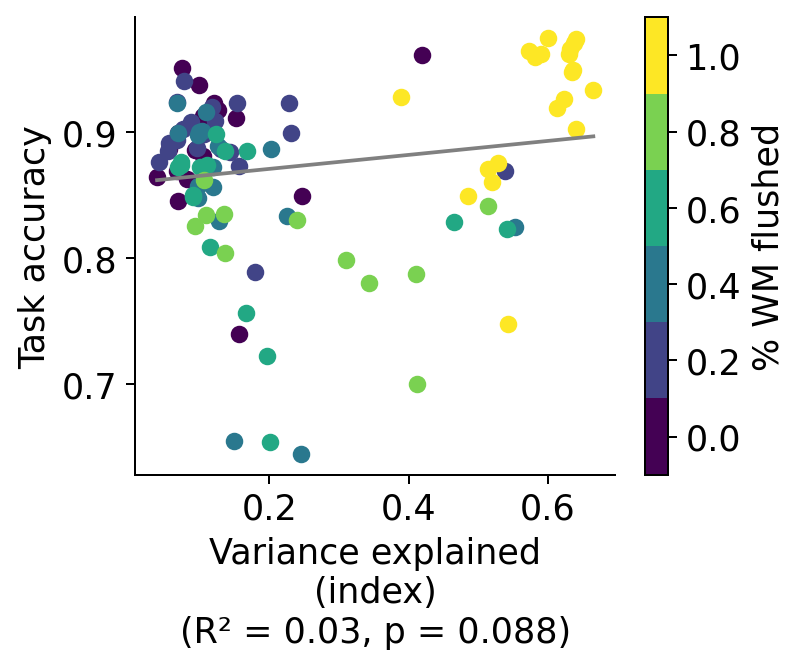

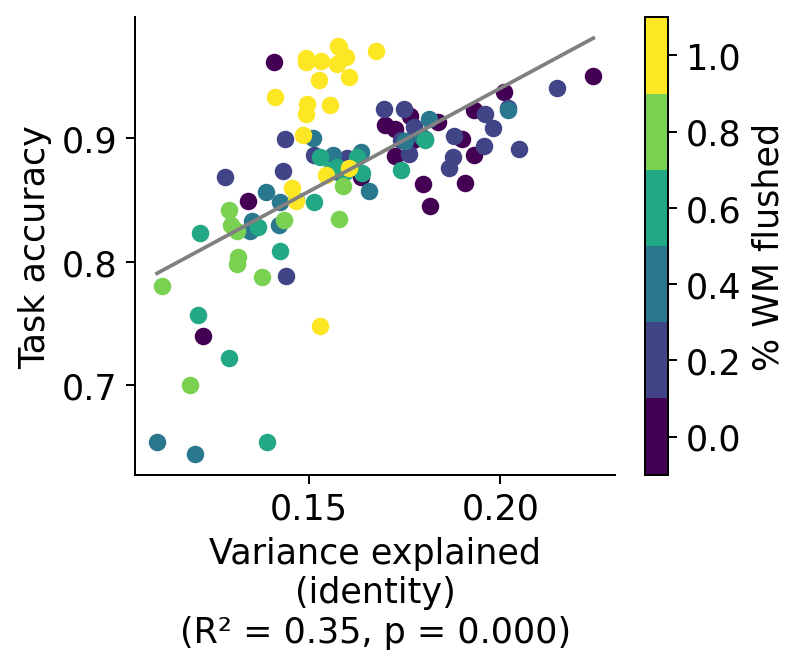

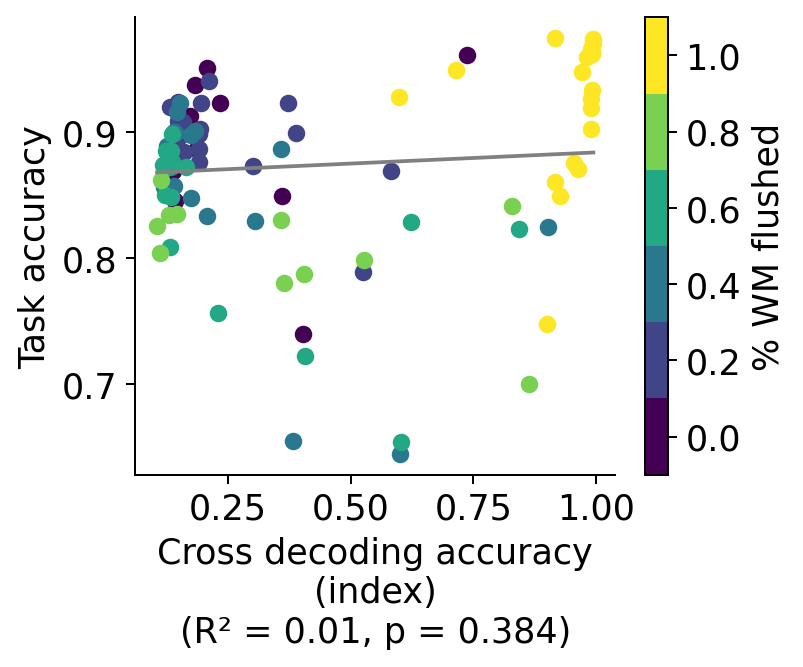

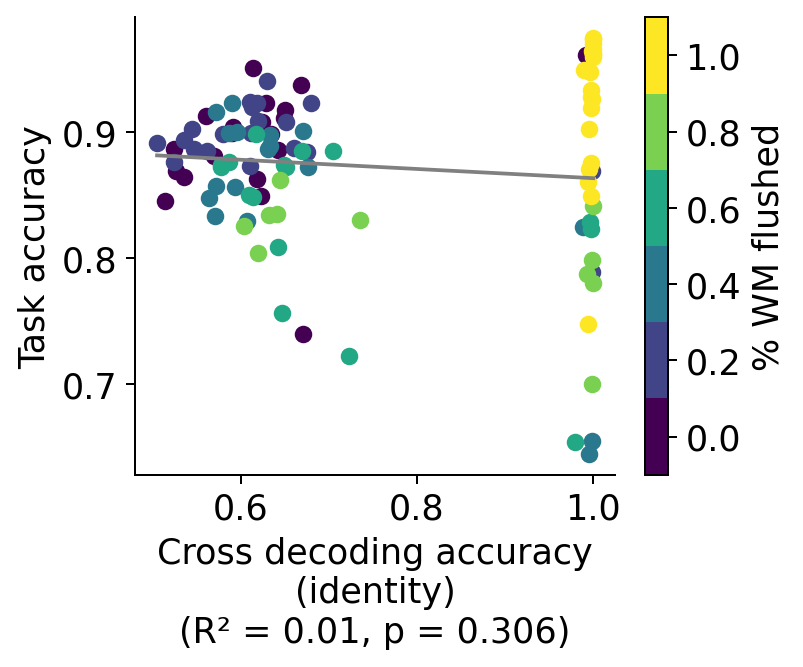

In [32]:
plot_scatter_by_group(df_noise_filtered, "forward_asymmetry", "accuracy", "noise_level", "Forward asymmetry", "Task accuracy", "% WM flushed")
plot_scatter_by_group(df_noise_filtered, "temporal_factor", "accuracy", "noise_level", "Temporal factor", "Task accuracy", "% WM flushed")
plot_scatter_by_group(df_noise_filtered, "explained_variance_index", "accuracy", "noise_level", "Variance explained\n(index)", "Task accuracy", "% WM flushed")
plot_scatter_by_group(df_noise_filtered, "explained_variance_identity", "accuracy", "noise_level", "Variance explained\n(identity)", "Task accuracy", "% WM flushed")
plot_scatter_by_group(df_noise_filtered, "cross_decoding_accuracy_index", "accuracy", "noise_level", "Cross decoding accuracy\n(index)", "Task accuracy", "% WM flushed")
plot_scatter_by_group(df_noise_filtered, "cross_decoding_accuracy_identity", "accuracy", "noise_level", "Cross decoding accuracy\n(identity)", "Task accuracy", "% WM flushed")
